## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the below prerequisites that must be downloaded. 

In [1]:
#@title Installs
!pip install transformers --quiet
!pip install tqdm boto3 requests regex sentencepiece sacremoses evaluate --quiet
!pip install rouge --quiet
!pip install better_profanity --quiet
!pip install rouge-score --quiet
!pip install -U evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 67.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.9 MB/s eta 0:

Imports

In [2]:
import torch
import pandas as pd
from tqdm import tqdm
# upload external file before import
from google.colab import files

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rouge import Rouge 
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import datetime
import string
import regex as re
from google.colab import drive

In [3]:
# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!ls "/content/drive/MyDrive/Colab Notebooks/data"

clean_dev.csv	clean_train.csv   original-test.tsv   test.csv
clean_test.csv	original-dev.tsv  original-train.tsv  train.csv


In [6]:
train_path='/content/drive/MyDrive/Colab Notebooks/data/original-train.tsv'
dev_path='/content/drive/MyDrive/Colab Notebooks/data/original-dev.tsv'
test_path='/content/drive/MyDrive/Colab Notebooks/data/original-test.tsv'

In [7]:
train=pd.read_csv(train_path,sep="\t", header=0) 
display(train[1:])

,offensive-text,style-transferred-text
1,"Ok, this makes no sense. This will create vigi...","Ok, this makes no sense. This will create vigi..."
2,so fucking true. the amount of up and coming r...,so true. the amount of up and coming rappers t...
3,Go f yourself Republican scum who put us here ...,Republicans put us in this situation. I would ...
4,Dumb fucking take. People want to do things.,That's not a smart take. People want to do thi...
5,Fuck no 😂,no
...,...,...
1579,The View! And this crap hits my front page!? l...,"This must be mostly bots but still, it's stran..."
1580,That’s racist.,Those actions are racist.
1581,Cultural Marxism isn't a thing you weird fuck.,Cultural Marxism isn't a thing.
1582,"LOL, anyone that questions the Democrat progra...","LOL, anyone that questions the Democrat progra..."


In [8]:
train['offensive-text'].str.len().max()

238

In [9]:
train['offensive-text'].str.len().min()

9

In [10]:
train['offensive-text'].str.len().mean()

69.85353535353535

In [11]:
train[train['style-transferred-text']=='']

,offensive-text,style-transferred-text


In [13]:
dev=pd.read_csv(dev_path,sep="\t", header=0) 
display(dev)

,offensive-text,style-transferred-text
0,Anyone who thinks canceling a pipeline and han...,Anyone who thinks canceling a pipeline and han...
1,My favorite part is that you’re still madly re...,My favorite part is that you are still replying.
2,But did you try it? Lol. That and medical mari...,Have you tried it? That helped my cousin's tin...
3,"By the downvotes, I see there are a bunch of u...","By the downvotes, I see there are a bunch of T..."
4,CUCKOLD Carlson is a problem,Carlson is the problem
...,...,...
193,Karma whore right here,Hunting for karma right here
194,Anyone who is still huffing paint thinner by c...,Anyone who is still huffing paint thinner by c...
195,And you have never made a stupid decision?,And you have never made a wrong decision?
196,You couldn't maybe just think about this for a...,You couldn't maybe just come up with the answe...


In [14]:
def read_process_data(df):
    # SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|()|()|(\%)|($)|(\>)|(\<)|(\{)|(\})")
    df["offensive-text"] = df["offensive-text"].str.lower()
    df["offensive-text"] = df["offensive-text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)

    df["offensive-text"] = df["offensive-text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ") #\n|\r|\r\n|

    df["style-transferred-text"] = df["style-transferred-text"].str.lower()
    df["style-transferred-text"] = df["style-transferred-text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)
    df["style-transferred-text"] = df["style-transferred-text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")
  
    df['offensive-text']=df['offensive-text'].astype(str).apply(lambda x: x.encode('latin-1', 'ignore').decode('latin-1'))
    df["style-transferred-text"] = df["style-transferred-text"].astype(str).apply(lambda x: x.encode('latin-1', 'ignore').decode('latin-1'))

    print('The null count :: ',df.isnull().sum())
    return df

In [15]:
# UNCOMMENT THIS ONE TO CREATE CLEANED DATASET : ONE TIME EFFORT
# x=read_process_data(train)
# x.to_csv('/content/drive/MyDrive/Colab Notebooks/data/clean_train.csv', header = False)
# z=read_process_data(test)
# z.to_csv('/content/drive/MyDrive/Colab Notebooks/data/clean_test.csv', header = False)
# y=read_process_data(dev)
# y.to_csv('/content/drive/MyDrive/Colab Notebooks/data/clean_dev.csv', header = False)

In [16]:
train_path='/content/drive/MyDrive/Colab Notebooks/data/clean_train.csv'
dev_path='/content/drive/MyDrive/Colab Notebooks/data/clean_dev.csv'
test_path='/content/drive/MyDrive/Colab Notebooks/data/clean_test.csv'

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

Below code is implementation of BART (Bidirectional and Auto-Regressive Transformer) model for sequence-to-sequence (seq2seq) tasks using PyTorch. The BART model is a variant of the Transformer model and is pre-trained on a large corpus of text data using a denoising autoencoder objective. It is capable of generating high-quality text with coherent sentence structures.

The code defines a PyTorch Dataset class MyDataset that reads the input and target text sequences from a text file and tokenizes them using the BART tokenizer. It then defines the collate_fn function to pad the sequences in each batch to the same length. The code then defines the BartEncoderDecoder class, which is the main model class that uses the BART encoder and decoder architecture.

The code instantiates the BART tokenizer and the BartEncoderDecoder model, and loads the training and validation data using the MyDataset class. It also defines the optimizer and loss function. The code then runs the training loop for a specified number of epochs, during which it trains the model on the training set and evaluates it on the validation set.

During training, the code iterates over the batches of training data and performs forward and backward passes through the model to compute the loss and update the model parameters using the Adam optimizer. The code also implements gradient accumulation by accumulating the gradients over a specified number of batches to reduce the memory requirements during training. After training on all the batches, the code computes the average loss over the entire training set and evaluates the model on the validation set.

During validation, the code iterates over the batches of validation data and generates the predicted text sequences using the generate method of the BART decoder. It then computes the loss between the predicted and target sequences and accumulates the loss over all the batches to compute the average loss over the entire validation set. Finally, the code prints the average training and validation loss for each epoch.

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from transformers import BartTokenizer, BartConfig, BartForConditionalGeneration,BartModel,AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from better_profanity import profanity
# the MyDataset class takes three arguments:

# data_path: The path to the training data file.
# tokenizer: The tokenizer used to preprocess the input data.
# max_seq_len: The maximum sequence length allowed for the input sequences.
# In the __init__ method, the training data is loaded from the specified file, and each line of text is stored in a list.

# In the __len__ method, the length of the dataset is returned (i.e., the number of lines in the training data file).

# In the __getitem__ method, an individual training example is retrieved based on the specified index. The input text is tokenized using the specified tokenizer and truncated to the specified maximum sequence length, and the resulting token ids are converted to a PyTorch tensor and returned as the training example.

# Instantiate BART tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base') 
profanity.load_censor_words()

class MyDataset(Dataset):
    def __init__(self, data_path, max_seq_len,kind):
        
        self.max_seq_len = max_seq_len

        self.toxic_ids = []
        self.non_toxic_ids = []
        self.masked_toxic_ids=[]

        c=0
        with open(data_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split(',')
                    toxic_seq = parts[1]
                    non_toxic_seq = parts[2]

                    censored_text = profanity.censor(toxic_seq)
                    masked_toxic_seq=censored_text.replace('****','<mask>')
               
                    toxic_ids = tokenizer(toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)  #, return_tensors='pt'
                    non_toxic_ids = tokenizer(non_toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)
                    masked_toxic_ids= tokenizer(masked_toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)
                    
                    self.toxic_ids.append(toxic_ids.input_ids)
                    self.non_toxic_ids.append(non_toxic_ids.input_ids)
                    self.masked_toxic_ids.append(masked_toxic_ids.input_ids)

                    if c==0:
                      print('\n',kind,' dataset preview .....')
                      print('*******************************************')
                      print('Input :: toxic        ::',toxic_seq)
                      print('Input :: masked toxic ::',masked_toxic_seq)
                      print('Input :: non toxic    ::',non_toxic_seq)
                      print('encoded length toxic :',toxic_ids)
                      print('encoded length masked toxic: ',masked_toxic_ids)
                      print('encoded length non toxic: ',non_toxic_ids)
                      print('*******************************************')
                    c=c+1
            print('total number of',kind,' data processed : ',c)

    def __len__(self):
        return len(self.toxic_ids)

    def __getitem__(self, index):
        toxic_ids = self.toxic_ids[index]
        non_toxic_ids = self.non_toxic_ids[index]
        masked_toxic_ids =self.masked_toxic_ids[index]

        # Create a PyTorch tensor from the tokenized sequences
        toxic_ids = torch.tensor(toxic_ids, dtype=torch.int64)
        non_toxic_ids = torch.tensor(non_toxic_ids, dtype=torch.int64)
        masked_toxic_ids = torch.tensor(masked_toxic_ids, dtype=torch.int64)

        return {'toxic_ids': toxic_ids, 'non_toxic_ids': non_toxic_ids, 'masked_toxic_ids': masked_toxic_ids}


In [17]:
#uncomment if memory issue happens. This will free up some space
# import torch
# torch.cuda.empty_cache()
BADWORDS = [
    'suck',
    'stupid',
    'pimp',
    'dumb',
    'homo',
    'slut',
    'damn',
    'ass',
    'rape',
    'poop',
    'cock',
    'lol',
    'crap',
    'sex',
    'nazi',
    'neo-nazi',
    'fuck',
    'bitch',
    'pussy',
    'penis',
    'vagina',
    'whore',
    'shit',
    'nigger',
    'nigga',
    'cocksucker',
    'assrape',
    'motherfucker',
    'wanker',
    'cunt',
    'faggot',
    'fags',
    'asshole',
    'piss',
    'cum',
    'moron',
    'cuckold',
    'shit' ,
    'filthy','retarded','screw','cucked'
]

In [ ]:
# bart_model=None

In [22]:
# Define hyperparameters

BATCH_SIZE = 16 #4
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5 #5e-5 #2e-4
WEIGHT_DECAY = 2e-5
MAX_SEQ_LEN = 128 #64
D_MODEL = 256 #dimensionality of the input and output vectors of the Transformer model. It is also commonly referred to as the "hidden size" of the model.POWER OF 2
NUM_HEADS = 4 #8 #number of attention heads used in multi-head attention (D_MODEL/NUM_HEADS=INT)
NUM_ENCODER_LAYERS = 4 #6
NUM_DECODER_LAYERS = 1 #1
DIM_FEEDFORWARD = 1024 #(4 times of D_MODEL)
DROPOUT = 0.3
GRADIENT_ACCUMULATION_STEPS = 2 #2  # accumulate gradients over 2 batches
HIDDEN_SIZE = 768

 # Define BART encoder-decoder model
class BartEncoderDecoder(nn.Module):
    def __init__(self, bart_config):
        super().__init__()

        self.encoder = BartModel.from_pretrained('facebook/bart-base') #The bare BART Model outputting raw hidden-states without any specific head on top.
        self.encoder.config = bart_config
        self.decoder = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
        self.decoder.config = bart_config
        self.bart_config=bart_config
       
    def forward(self, input_ids, masked_input):

        # Generate hidden representations for the modified input sequence using the encoder
        encoder_outputs = self.encoder(input_ids=input_ids)

        # Pass the modified input sequence as input to the decoder and generate the output sequence
        decoder_input_ids = masked_input#.new_full((input_ids.size(0), input_ids.size(1)), self.bart_config.decoder_start_token_id)
        decoder_outputs = self.decoder(input_ids=decoder_input_ids, encoder_outputs=encoder_outputs.encoder_last_hidden_state)
        
        return decoder_outputs

# Instantiate BART encoder-decoder model
bart_config = BartConfig(d_model=D_MODEL, encoder_layers=NUM_ENCODER_LAYERS, decoder_layers=NUM_DECODER_LAYERS, 
                         encoder_attention_heads=NUM_HEADS, decoder_attention_heads=NUM_HEADS,
                         encoder_ffn_dim=DIM_FEEDFORWARD, decoder_ffn_dim=DIM_FEEDFORWARD, dropout=DROPOUT, hidden_size=HIDDEN_SIZE) #
bart_model = BartEncoderDecoder(bart_config).cuda() # move the model to CUDA

In [23]:
def loss_fn(outputs, targets):
    batch_size, seq_len, vocab_size = outputs.logits.shape
    outputs = outputs.logits.view(batch_size * seq_len, vocab_size)
    
    # Reshape the targets tensor to (batch_size * seq_len)
    targets = targets.view(-1)
    loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)(outputs, targets)
    return loss

def collate_fn(batch, batch_size=BATCH_SIZE):
    # Pad sequences in batch to have the same length
    toxic_ids = pad_sequence([item['toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    masked_toxic_ids = pad_sequence([item['masked_toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    non_toxic_ids = pad_sequence([item['non_toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)

    # Split data into batches of the desired size
    num_batches = len(batch) // batch_size
    if len(batch) % batch_size != 0:
        num_batches += 1
    toxic_batches = list(torch.split(toxic_ids[:num_batches*batch_size], batch_size))
    masked_toxic_batches = list(torch.split(masked_toxic_ids[:num_batches*batch_size], batch_size))
    non_toxic_batches = list(torch.split(non_toxic_ids[:num_batches*batch_size], batch_size))

    # Pad the last batch to ensure that all batches have the same size
    if len(toxic_batches[-1]) < batch_size:
        toxic_batches[-1] = nn.functional.pad(toxic_batches[-1], (0, 0, 0, batch_size - len(toxic_batches[-1])), value=tokenizer.pad_token_id)
        masked_toxic_batches[-1] = nn.functional.pad(masked_toxic_batches[-1], (0, 0, 0, batch_size - len(masked_toxic_batches[-1])), value=tokenizer.pad_token_id)
        non_toxic_batches[-1] = nn.functional.pad(non_toxic_batches[-1], (0, 0, 0, batch_size - len(non_toxic_batches[-1])), value=tokenizer.pad_token_id)

    return [{'toxic_ids': t, 'non_toxic_ids': nt,'masked_toxic_ids': mt} for t, nt, mt in zip(toxic_batches, non_toxic_batches,masked_toxic_batches)][0]

# def get_bad_word_indices(batch, bad_word_ids):
#     bad_word_indices_batch = []
#     for src in batch:
#         bad_word_indices = [i for i in range(len(src)) if src[i] in bad_word_ids]
#         bad_word_indices_batch.append(bad_word_indices)
#     return bad_word_indices_batch

In [20]:
bart_model

BartEncoderDecoder(
  (encoder): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05, element

In the line source_embeddings = bart_model.encoder(input_ids=src)[0][:, 0, :], bart_model.encoder(input_ids=src) applies the BART encoder to the input sequence src and returns a tuple of encoder hidden states, attention weights, and the final hidden state of the last layer.

The [0] at the end of the function call accesses only the encoder hidden states from the tuple. The [:, 0, :] at the end selects the first token embedding for each input sequence in the batch. The first dimension : means that we want all the input sequences in the batch. The second dimension 0 selects only the first token embedding for each sequence, and the third dimension : selects all the features (or dimensions) in the embedding vector.

The first token embedding is often referred to as the "CLS" token embedding, and it typically contains information about the overall sequence, which is useful for tasks such as sequence classification or sentence pair classification. In this case, the first token embedding is used to compute the similarity loss between the source and target embeddings.

In [25]:
import torch.autograd as autograd
# CUDA_LAUNCH_BLOCKING=1

# Load training and validation data
train_data = MyDataset(train_path, MAX_SEQ_LEN,'training')
val_data = MyDataset(dev_path, MAX_SEQ_LEN,'validation')

print('Instatiating Data loaders for training and validation dataset ......')
# Instantiate data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_fn)

def train(train_loader,learning_rate=LEARNING_RATE, epochs=NUM_EPOCHS, verbose=True, batch_size=BATCH_SIZE):
  autograd.set_detect_anomaly(True)

  # Instantiate optimizer and loss function
  optimizer = Adam(bart_model.parameters(), lr=learning_rate) #, weight_decay=WEIGHT_DECAY
  train_losses=[]
  
  print('\nTokenizer information :: ')
  print('eos_token_id :',tokenizer.eos_token_id)
  print('pad_token_id :',tokenizer.pad_token_id)
  print('bos_token_id :', tokenizer.bos_token_id)
  print('sep_token_id :', tokenizer.sep_token_id,'\n')

  # start time
  t0 = time.time()

  # Training loop
  for epoch in range(epochs):
      print ('######  Epoch {}/{} ######'.format(epoch+1, epochs))
      
      # Train the model
      bart_model.train()
      train_loss = 0
      epoch_loss=0
      for step, batch in enumerate(train_loader):
          src = batch['toxic_ids'].cuda()
          tgt = batch['non_toxic_ids'].cuda()
          masked_src=batch['masked_toxic_ids'].cuda()

          optimizer.zero_grad()
          outputs=bart_model(input_ids=src, masked_input=masked_src)

          loss = loss_fn(outputs, tgt.cuda())
          loss = loss.mean() # reduce the loss tensor to a scalar tensor by taking the mean
          loss /= GRADIENT_ACCUMULATION_STEPS

          loss.backward()
          if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()

          epoch_loss += loss.item()

          # Report progress every batch
          if verbose and step % 10 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, step+1, len(train_loader), loss.item()))

      avg_loss = epoch_loss / len(train_loader)
      train_losses.append(avg_loss)

      elapsed_time = time.time() - t0
      if verbose:
          print('Epoch [{}/{}], Average Loss: {:.4f}, Elapsed Time: {}'.format(epoch+1, epochs, avg_loss, format_time(elapsed_time)))

  return train_losses, sum(train_losses) / len(train_losses)

train_losses,avg_loss=train(train_loader)


 training  dataset preview .....
*******************************************
Input :: toxic        :: pussy nobody asked for your input
Input :: masked toxic :: <mask> nobody asked for your input
Input :: non toxic    :: nobody asked for your input
encoded length toxic : {'input_ids': [0, 642, 28102, 5907, 553, 13, 110, 8135, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [14]:
#uncomment below one only in case of cuda memory issue
# import torch
# torch.cuda.empty_cache()

In [26]:
train_losses

[3.1099795428189365, 2.787871083827934, 2.7002994725198457, 2.631297012772223]

In [27]:

torch.save(bart_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models/bart_model_checkpoint.pth')
# download checkpoint file
files.download('/content/drive/MyDrive/Colab Notebooks/models/bart_model_checkpoint.pth')
# bart_model = bart_model.cuda()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/models/bart_model_checkpoint.pth')
print(state_dict.keys())

odict_keys(['encoder.shared.weight', 'encoder.encoder.embed_tokens.weight', 'encoder.encoder.embed_positions.weight', 'encoder.encoder.layers.0.self_attn.k_proj.weight', 'encoder.encoder.layers.0.self_attn.k_proj.bias', 'encoder.encoder.layers.0.self_attn.v_proj.weight', 'encoder.encoder.layers.0.self_attn.v_proj.bias', 'encoder.encoder.layers.0.self_attn.q_proj.weight', 'encoder.encoder.layers.0.self_attn.q_proj.bias', 'encoder.encoder.layers.0.self_attn.out_proj.weight', 'encoder.encoder.layers.0.self_attn.out_proj.bias', 'encoder.encoder.layers.0.self_attn_layer_norm.weight', 'encoder.encoder.layers.0.self_attn_layer_norm.bias', 'encoder.encoder.layers.0.fc1.weight', 'encoder.encoder.layers.0.fc1.bias', 'encoder.encoder.layers.0.fc2.weight', 'encoder.encoder.layers.0.fc2.bias', 'encoder.encoder.layers.0.final_layer_norm.weight', 'encoder.encoder.layers.0.final_layer_norm.bias', 'encoder.encoder.layers.1.self_attn.k_proj.weight', 'encoder.encoder.layers.1.self_attn.k_proj.bias', 'enc

Model Hyperparamters fine tuning :  
In intial attempts we observed that generated text was very small in comparison to golden text. There could be several reasons why the generated text is very short with the given decoding parameters.

One possibility is that the model is more likely to stop early when the most probable token indicates the end of the sentence. To address this, you may want to experiment with adjusting the decoding parameters, such as the length penalty or the minimum and maximum length constraints, to encourage the model to generate longer text.

Another possibility is that the input may not provide enough context or information for the model to generate longer text. In this case, you may want to consider using a larger input sequence or incorporating additional information or features, such as metadata or external knowledge, to provide more context and guidance for the model.

It's also worth noting that the number of returned sequences is set to 2, which may limit the diversity and length of the generated text. Increasing the number of return sequences, such as 5 or 10, may help generate longer and more diverse outputs.

After fine tuning generate method,we observed that model started performing little well in case of short sentences.

We had a choice to use decoder.generate or decoder.outputs to get generated token ids. We will be using generate method. torch.argmax(outputs.logits, dim=-1) gives the index of the highest logit value for each position in the output sequence. This is not the same as the sequence of generated IDs produced by decoder.generate(), because decoder.generate() applies several additional steps during decoding, such as beam search and top-k sampling, that are not present in a simple argmax operation.

The decoder.generate() method in BART uses beam search to generate multiple possible sequences, and then returns the highest-scoring sequence according to a scoring function that takes into account both the log-likelihood of the sequence and various penalties for things like repeated n-grams. This process is more complex than simply taking the argmax of the logits, and can lead to better quality generated sequences.

In [29]:
import torch.optim as optim

def get_max_length(input_sequence):
    # Return a multiple of the input sequence length as the maximum length
    return 1.5 * len(input_sequence)

bart_model=bart_model.cuda()
def validate(model, val_loader, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, optimizer_type='Adam', epochs=NUM_EPOCHS,verbose=True):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_type == 'Adam' else optim.SGD(model.parameters(), lr=learning_rate)
    model.eval()
    
    total_tokens = 0
    val_losses=[]
    generated_texts = []
    gold_texts = []
    t0 = time.time()

    with torch.no_grad():
      for epoch in range(epochs):
        print ('######  Epoch {}/{} ######'.format(epoch+1, epochs))
        epoch_loss=0
        for step,batch in enumerate(val_loader):
            src = batch['toxic_ids'].cuda()
            tgt = batch['non_toxic_ids'].cuda()
            masked_src=batch['masked_toxic_ids'].cuda()

            # Perform style transfer       
            # generate translations
            generated_ids = model.decoder.generate(
                input_ids=masked_src.cuda(),
                max_length=get_max_length(masked_src.cuda()),
                num_beams=10,
                early_stopping=True,
                top_k=50,
                length_penalty=1,
                repetition_penalty=1.8,
                no_repeat_ngram_size=1,
                top_p = 0.95,
                temperature=0.1,
                decoder_start_token_id=bart_config.decoder_start_token_id
            )

            generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            generated_texts.extend(generated_text)

            gold_text = tokenizer.batch_decode(tgt[:, 1:], skip_special_tokens=True)
            gold_texts.extend(gold_text)
       
            # Compute loss
            outputs=bart_model(input_ids=src, masked_input=masked_src)

            loss = loss_fn(outputs, tgt.cuda())               
            epoch_loss += loss.item()
            
        # Report progress every batch
        if verbose and step % 1 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, step+1, len(val_loader), loss.item()))

        avg_loss = epoch_loss / len(val_loader)
        val_losses.append(avg_loss)

        elapsed_time = time.time() - t0
        if verbose:
            print('Epoch [{}/{}], Average Loss: {:.4f}, Elapsed Time: {}'.format(epoch+1, epochs, avg_loss, format_time(elapsed_time)))

    return val_losses,avg_loss, generated_texts, gold_texts

val_loss,avg_loss, generated_texts, gold_texts=validate(bart_model, val_loader, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, optimizer_type='Adam') #'SGD'


######  Epoch 1/4 ######
Epoch [1/4], Step [13/13], Loss: 5.0085
Epoch [1/4], Average Loss: 5.1585, Elapsed Time: 0:00:23
######  Epoch 2/4 ######
Epoch [2/4], Step [13/13], Loss: 5.0085
Epoch [2/4], Average Loss: 5.1585, Elapsed Time: 0:00:41
######  Epoch 3/4 ######
Epoch [3/4], Step [13/13], Loss: 5.0085
Epoch [3/4], Average Loss: 5.1585, Elapsed Time: 0:01:00
######  Epoch 4/4 ######
Epoch [4/4], Step [13/13], Loss: 5.0085
Epoch [4/4], Average Loss: 5.1585, Elapsed Time: 0:01:18


In [30]:
val_loss

[5.158451263721172, 5.158451263721172, 5.158451263721172, 5.158451263721172]

In [32]:
# rouge.compute(predictions=generated_texts,references=gold_texts)

{'rouge1': 0.4555623065240082,
 'rouge2': 0.33827751878462214,
 'rougeL': 0.4412164887835873,
 'rougeLsum': 0.4416998893351898}

In [33]:
# print(bleu.compute(predictions=generated_texts,references=gold_texts))

{'bleu': 0.258580189534991, 'precisions': [0.38265556099951004, 0.28471863706763034, 0.22776868521549373, 0.18016194331983806], 'brevity_penalty': 1.0, 'length_ratio': 1.7541899441340782, 'translation_length': 16328, 'reference_length': 9308}


In [31]:
dev=pd.read_csv(dev_path,sep=",", header=None) 

for i in range(len(generated_texts[:10])):
  print(i,'*'*20)
  print(' Original text   :: ',dev[1][i])
  print(' Gold text       :: ',gold_texts[i])
  print(' Translated text :: ',generated_texts[i])


0 ********************
 Original text   ::  anyone who thinks canceling a pipeline and handcuffing fossil energy production in the us would have no effect on gas prices is a fucking moron
 Gold text       ::  anyone who thinks canceling a pipeline and handcuffing fossil energy production in the us would have no effect on gas prices is not thinking about this
 Translated text ::  anyone who thinks canceling a pipeline and handcuffing fossil energy production in the us would have no
1 ********************
 Original text   ::  my favorite part is that youre still madly replying as if its going to quell your cousin fucking urges
 Gold text       ::  my favorite part is that you are still replying
 Translated text ::  my favorite part is that youre still madly replying as if its going to quell your cousin
2 ********************
 Original text   ::  but did you try it lol that and medical marijuana helped my cousins tinnitus she used to puke cause she would be so dizzy
 Gold text       ::  h

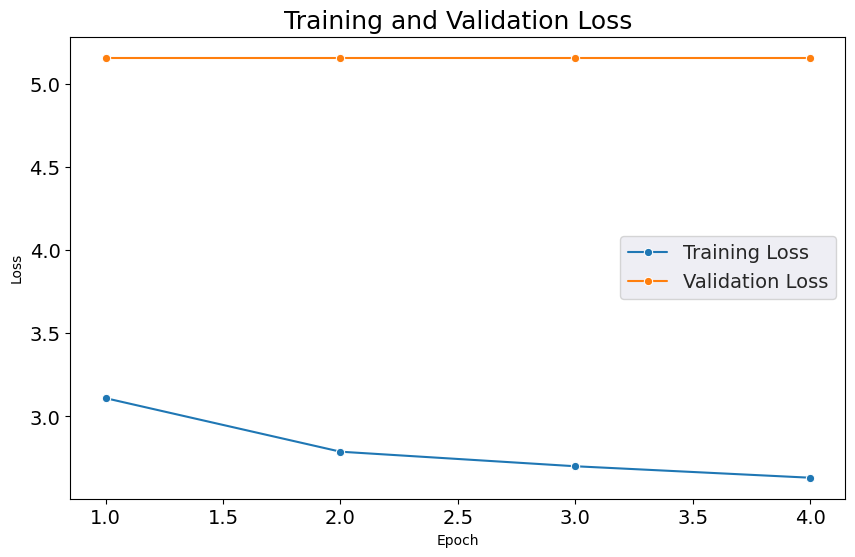

In [32]:
import seaborn as sns
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_losses, 'Validation Loss': val_loss}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [34]:
test_data = MyDataset(test_path, MAX_SEQ_LEN,'test') 
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_fn)



 test  dataset preview .....
*******************************************
Input :: toxic        :: so maybe you should be more retarded
Input :: masked toxic :: so maybe you should be more <mask>
Input :: non toxic    :: so maybe you should be more backward
encoded length toxic : {'input_ids': [0, 2527, 2085, 47, 197, 28, 55, 47304, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [35]:
from nltk.translate.bleu_score import SmoothingFunction
import evaluate

rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')


# Define a smoothing function for Rouge-L
smoothie = SmoothingFunction().method4

def model_evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    # Calculate the evaluation metrics
    total_correct = 0
    total_predicted = 0
    total_gold = 0
    total_batches = 0

    total_rouge1 = 0
    total_rouge2 = 0
    total_rougel = 0
    total_rougelsum = 0
    total_gen_len = 0

    golden_texts=[]
    predicted_generated_text=[]
    bleu_scores = []
    rouge = Rouge()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            toxic_src = batch['toxic_ids'].cuda()
            non_toxic_tgt = batch['non_toxic_ids'].cuda()
            masked_toxic_src= batch['masked_toxic_ids'].cuda()
            
            generated_ids = model.decoder.generate(
                input_ids=masked_toxic_src.cuda(),
                max_length=get_max_length(masked_toxic_src.cuda()),
                num_beams=10,
                early_stopping=True,
                top_k=50, 
                length_penalty=1,
                repetition_penalty=1.8,
                no_repeat_ngram_size=1,
                top_p = 0.95,
                temperature=0.1,
                decoder_start_token_id=bart_config.decoder_start_token_id
            )

            predicted_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            predicted_generated_text.extend(predicted_text)

            gold_text = tokenizer.batch_decode(non_toxic_tgt[:, 1:], skip_special_tokens=True)
            golden_texts.extend(gold_text)

            #calculating cross entropy loss
            outputs=bart_model(input_ids=toxic_src, masked_input=masked_toxic_src)
            loss = loss_fn(outputs, non_toxic_tgt.cuda())
            
            total_loss += loss.item()
            
            # print('per batch analysis',len(predicted_generated_text),len(golden_texts))
            for i, (predicted_sent, gold_sent) in enumerate(zip(predicted_generated_text, golden_texts)):
                # Calculate the number of correct tokens
                
                correct_tokens = sum([1 for p, g in zip(predicted_sent, gold_sent) if p == g])
                total_correct += correct_tokens
                
                # Calculate the number of predicted and gold tokens
                predicted_tokens = len(predicted_sent)
                total_predicted += predicted_tokens
                
                gold_tokens = len(gold_sent.split())
                total_gold += gold_tokens
               
            # Calculate average generated length
            total_gen_len += sum([len(sent.split()) for sent in predicted_text])
            total_batches += 1*len(predicted_text)


    print('number of records in test',total_batches)     

    # Calculate average metrics for the entire dataset
    avg_loss = total_loss / total_batches
    avg_accuracy = total_correct / total_predicted if total_predicted > 0 else 0
    avg_precision = total_correct / total_predicted if total_predicted > 0 else 0
    avg_recall = total_correct / total_gold if total_gold > 0 else 0
    avg_f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall) if avg_precision + avg_recall > 0 else 0

    print("Loss: {:.4f}".format(avg_loss))
    print("Accuracy: {:.4f}".format(avg_accuracy))
    print("Precision: {:.4f}".format(avg_precision))
    print("Recall: {:.4f}".format(avg_recall))
    print("F1 Score: {:.4f}".format(avg_f1))

    return predicted_generated_text,golden_texts

predicted_generated_text,golden_texts=model_evaluate(bart_model, test_loader)


100%|██████████| 13/13 [00:18<00:00,  1.42s/it]

number of records in test 208
Loss: 0.3307
Accuracy: 0.2257
Precision: 0.2257
Recall: 1.9080
F1 Score: 0.4036


In [36]:
rouge.compute(predictions=predicted_generated_text,references=golden_texts)

{'rouge1': 0.45199103357105713,
 'rouge2': 0.33482607760280103,
 'rougeL': 0.44002654454764517,
 'rougeLsum': 0.43953254586099044}

In [37]:
print(bleu.compute(predictions=predicted_generated_text,references=golden_texts))

{'bleu': 0.2574509671639229, 'precisions': [0.38116154221571497, 0.2832904884318766, 0.2265073329712113, 0.17962003454231434], 'brevity_penalty': 1.0, 'length_ratio': 1.7610657498925655, 'translation_length': 4098, 'reference_length': 2327}


In [ ]:
# import gc
# gc.collect()

3132

In [38]:
df_test=pd.read_csv(test_path,sep=",", header=None) 

for i in range(len(predicted_generated_text[:5])):
  print(' Original text   :: ',df_test[1][i])
  print(' Gold text       :: ',df_test[2][i])
  print(' Translated text :: ',predicted_generated_text[i])

# Create a new DataFrame with the generated texts
df_gen = pd.DataFrame({'bart_tuning_output': predicted_generated_text}) 

# Add the generated_text column to the df_test dataframe
df_bart_output = pd.concat([df_test, df_gen], axis=1)

# Save the updated dataframe as a CSV file
df_bart_output=df_bart_output.drop([0],axis=1)
df_bart_output=df_bart_output[:-1]
df_bart_output.to_csv('/content/drive/MyDrive/Colab Notebooks/outputs/bart_tuning_output.csv',sep='\t',index=False,header=['toxic_text','gold_text','bart_tuning_output'])

 Original text   ::  so maybe you should be more retarded
 Gold text       ::  so maybe you should be more backward
 Translated text ::  so maybe you should be more concerned about your own health and well-being than the people who are around
 Original text   ::  theres a megathread for vaccine or covid related topics don t talk about that shit here idiot
 Gold text       ::  theres actually a megathread for vaccine or covid related topics don t talk about that stuff here
 Translated text ::  theres a megathread for vaccine or covid related topics don t talk about that stuff here idiot
 Original text   ::  the fuck you are on drugs
 Gold text       ::  uh you are not being realistic
 Translated text ::  the only reason you are on drugs is because it makes sense to feel that way about people when they think
 Original text   ::  nta dump his ass tablemanners are no rocket science treating other people like human beings is no rocket science his still a child
 Gold text       ::  you shoul

In [39]:
output_file = '/content/drive/MyDrive/Colab Notebooks/outputs/bart_tuning_output.csv'
sample=pd.read_csv(output_file, sep="\t")
sample[:5]

,toxic_text,gold_text,bart_tuning_output
0,so maybe you should be more retarded,so maybe you should be more backward,so maybe you should be more concerned about yo...
1,theres a megathread for vaccine or covid relat...,theres actually a megathread for vaccine or co...,theres a megathread for vaccine or covid relat...
2,the fuck you are on drugs,uh you are not being realistic,the only reason you are on drugs is because it...
3,nta dump his ass tablemanners are no rocket sc...,you should leave him tablemanners are no rocke...,nta dump his food on the table because he does...
4,youre soft as baby shit,youre really soft,youre soft as baby when it comes to your own b...


In [40]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/notebooks')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/models')

In [41]:
# %cd '/content/drive/MyDrive/Colab Notebooks/notebooks'
# !pwd

In [42]:
ls

drive/  sample_data/


In [43]:
from DistilBertClassification import BertClassificationML, NonToxicScoreDataLoader, NonToxicScore

# Load DistilBERT Classification Model to calculate NonToxicScore
score_model = BertClassificationML()
score_model = score_model.to(device)

# Load training weights
pretrained_weights = torch.load('/content/drive/MyDrive/Colab Notebooks/models/DistilBertToxicClassification5.pth')
score_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [44]:
output_file = '/content/drive/MyDrive/Colab Notebooks/outputs/bart_tuning_output.csv'
output_col = 'bart_tuning_output'

# Create Data Loader
score_loader = NonToxicScoreDataLoader(output_file, output_col)

# Calculate NonToxicScore
bart_NonToxicScores, avg_score = NonToxicScore(score_loader, score_model)

{'NonToxicScore': 0.4607024194227289}
